In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from itertools import combinations
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

Text(0, 0.5, 'Longitude')

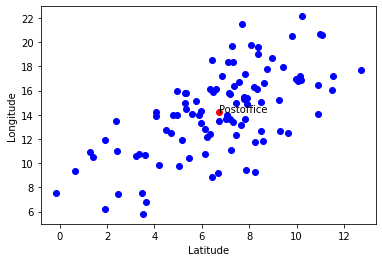

In [2]:
# Generating random points for locations
cov = np.array([[3, 7], [7, 3]])
mean_1 = [5, 10]
mean_2 = [6, 14]
mean_3 = [8, 17]

x_class1 = np.random.multivariate_normal(mean_1, cov, 20)
x_class2 = np.random.multivariate_normal(mean_2, cov, 40)
x_class3 = np.random.multivariate_normal(mean_3, cov, 40)

data = np.append(x_class1 , np.append(x_class2 ,x_class3, axis=0), axis=0)

data = np.append(data,np.array([data.mean(axis=0)[0],data.mean(axis=0)[1]]).reshape(-1,2), axis=0)
plt.scatter(data[:-1,0],data[:-1,1], c="blue")
plt.scatter(data[-1,0],data[-1,1], c="red")
plt.annotate('Postoffice', xy =(data.mean(axis=0)[0], data.mean(axis=0)[1]))
plt.xlabel("Latitude")
plt.ylabel("Longitude")

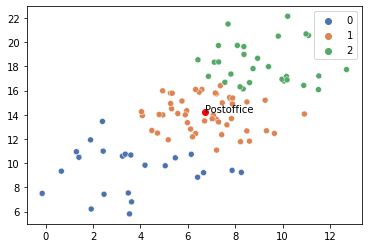

In [3]:
# Applying K-means clustering to classify data into 3 clusters
from sklearn.cluster import KMeans

kmeans = KMeans(
    n_clusters=3, init='random',
    n_init=10, max_iter=300, 
    tol=1e-04, random_state=0
)

kmeans.fit(data[:-1,:])

# Plotting locations with clusters
sns.scatterplot(data[:-1,0],data[:-1,1], hue=kmeans.labels_, palette="deep")
plt.scatter(data[-1,0],data[-1,1], c="red")
plt.annotate('Postoffice', xy =(data.mean(axis=0)[0], data.mean(axis=0)[1]))
plt.show()

In [4]:
# Creating complete dataframe with locations and address names
df = pd.DataFrame(columns = ['Lat', 'Long', 'Cluster', 'Address'])
for i in range(data[:-1,:].shape[0]):
    df = df.append({'Lat' : data[i,0], 'Long' : data[i,1], 'Cluster' : kmeans.labels_[i], 'Address' : 'A'+str(i)}, ignore_index = True)

In [5]:
# Selecting one cluster
df_1 = df[df.loc[:,'Cluster'] == 0]
df_postoffice = pd.DataFrame({'Lat' : data[-1,0], 'Long' : data[-1,1], 'Cluster' : '', 'Address' : 'Postoffice'}, index=[0])
df_1 = df_postoffice.append(df_1, ignore_index = True)

# Generating distance matrix with distnace between same location to same as infinity
dist_arr = np.empty([df_1.shape[0], df_1.shape[0]])
for i in range(df_1.shape[0]):
    for j in range(df_1.shape[0]):
        if(i!=j):
            dist_arr[i,j] = np.sqrt(np.square(df_1.iloc[j,0]-df_1.iloc[i,0]) + np.square(df_1.iloc[j,1]-df_1.iloc[i,1]))
        else:
            dist_arr[i,j] = float('inf')

# Gererating a dataframe for cost associated with each node
df_path = pd.DataFrame(columns = ['Address', 'Cost', 'Lat', 'Long'])
for i in range(df_1.shape[0]):
    if(df_1.loc[i, 'Address'] == 'Postoffice'):
        df_path = df_path.append({'Address' : df_1.loc[i, 'Address'], 'Cost' : 0, 'Lat' : data[-1,0], 'Long' : data[-1,1]}, ignore_index = True)
    else:
        df_path = df_path.append({'Address' : df_1.loc[i, 'Address'], 'Cost' : float('inf'), 'Lat' : df_1.loc[i, 'Lat'], 'Long' : df_1.loc[i, 'Long']}, ignore_index = True)

In [6]:
# applying STRATEGY2 algorithm
address_visited = ['Postoffice']
current_node_index = 0
current_node_cost = df_path.iloc[current_node_index,1]

while(len(address_visited)<df_path.shape[0]):
    lst = df_path.index[~df_path.loc[:,'Address'].isin(address_visited)]
    
    for j in lst:
        new_cost = current_node_cost + dist_arr[current_node_index,j]
        if df_path.iloc[j,1]>new_cost:
            df_path.iloc[j,1] = new_cost
    
    z = df_path.loc[df_path.index[~df_path.loc[:,'Address'].isin(address_visited)],['Address','Cost']]
    current_node_index = z.index[z['Cost']==z['Cost'].min()][0]
    address_visited.append(df_path.iloc[current_node_index,0])
    current_node_cost = df_path.iloc[current_node_index,1]
        
display(df_path)

,Address,Cost,Lat,Long
0,Postoffice,0,6.742349,14.213762
1,A2,6.508916,1.406806,10.485764
2,A4,5.359757,1.897222,11.922094
3,A6,4.999109,6.666657,9.215226
4,A7,7.427879,3.489086,7.536213
5,A8,5.384996,6.4153,8.838706
6,A9,8.995684,3.540234,5.807289
7,A10,8.016762,2.466293,7.432625
8,A11,9.616372,-0.143996,7.501618
9,A12,5.041915,3.244584,10.582433


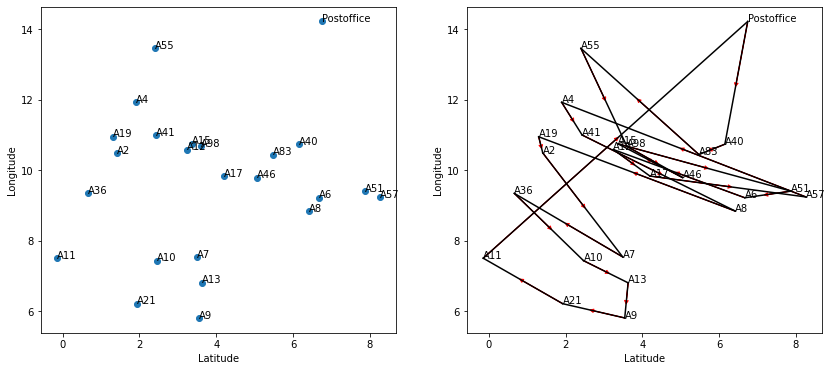

In [7]:
# Plotting path traversed in the cluster
address_visited.append("Postoffice")
fig, axs = plt.subplots(1,2,figsize=(14, 6))
axs = axs.ravel()

axs[0].scatter(df_1.iloc[:,0],df_1.iloc[:,1])
for i in range(df_1.shape[0]):
    axs[0].annotate(df_1.iloc[i,3], xy =(df_1.iloc[i,0], df_1.iloc[i,1]))
    
for i in range(len(address_visited)-1):
    x1 = df_1.loc[df_1.loc[:,'Address']==address_visited[i],'Lat'].values[0]
    x2 = df_1.loc[df_1.loc[:,'Address']==address_visited[i+1],'Lat'].values[0]
    y1 = df_1.loc[df_1.loc[:,'Address']==address_visited[i],'Long'].values[0]
    y2 = df_1.loc[df_1.loc[:,'Address']==address_visited[i+1],'Long'].values[0]
    axs[1].arrow(x1, y1, (x2-x1)/2, (y2-y1)/2, head_length=0.1, overhang = 0.2, head_width = 0.1, fc='red', ec='red')
    axs[1].plot([x1,x2],[y1,y2], c='black')
    axs[1].annotate(df_1.iloc[i,3], xy =(df_1.iloc[i,0], df_1.iloc[i,1]))
    
axs[0].set_xlabel("Latitude")
axs[0].set_ylabel("Longitude")
axs[1].set_xlabel("Latitude")
axs[1].set_ylabel("Longitude")
    
plt.show()